## Check spatial correlation for new and old model

In [1]:
# this path append is for binder only
import sys
sys.path.append("../../")

#spectrome modules
from spectrome.forward import runforward_spatialcorrelation
from spectrome.utils import functions, path
from spectrome.brain import Brain

#generic modules
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy import stats

plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

## Following is to generate individual connectomes and PSD

In [2]:
# external function from matlab:
def get_mean_C(C):
    #C = np.mean(C, axis = 2)
    C = (C + np.transpose(C))/2
    
    ss = np.argsort(-C[:])
    C = np.minimum(C, ss[int(np.round(0.01*len(ss)))])
    return C

# define data directory
data_dir = path.get_data_path()

# cortical areas with MEG collected + source reconstructed
rois_with_MEG = np.arange(0,68)

## individual connectomes, this is a Nregion x Nregion x Nsubjects array:
ind_conn_xr = xr.open_dataarray(data_dir + '/individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

## individual MEG spectra
ind_psd_xr = xr.open_dataarray(data_dir + '/individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values

ind_psd_db = functions.mag2db(ind_psd)

fvec = ind_psd_xr["frequencies"].values

## Function to get spatial correlations

In [3]:
def subsc(cdk,psd,rois_with_MEG,fvec,band,SC,s):

    C_ind = cdk[:,:,s] # grab current subject's individual connectome
    F_ind = psd[rois_with_MEG,:,s] # grab current subject's MEG

    data_dir = path.get_data_path()
    # create spectrome brain:
    brain = Brain.Brain()
    brain.add_connectome(data_dir) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome = C_ind # re-assign connectome to individual connectome
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    brain.distance_matrix = get_mean_C(brain.distance_matrix)
    brain.ntf_params["tau_e"] = optparam[s,0]/1000
    brain.ntf_params["tau_i"] = optparam[s,1]/1000
    brain.ntf_params["alpha"] = optparam[s,2]
    brain.ntf_params["speed"] = optparam[s,3]
    brain.ntf_params["gei"] = optparam[s,4]
    brain.ntf_params["gii"] = optparam[s,5]
    brain.ntf_params["tauC"] = optparam[s,6]/1000

    corr, eigvec_sorted, summed_PSD, eig_ind = runforward_spatialcorrelation.run_local_coupling_forward_Xk(brain, brain.ntf_params, fvec, F_ind, SC, rois_with_MEG,band)
    
    return corr, eigvec_sorted, summed_PSD, eig_ind

## Spatial correlations for the alpha frequency band

Ignore the warning about Pearson's r since it is for the 4 regions for which connectome information was not available and therefore the eigenvectors are zero.

/Users/parul/Software/miniconda3/envs/spectrome/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/parul/Software/miniconda3/envs/spectrome/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/parul/Software/miniconda3/envs/spectrome/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


0.5111978046099173
0.6620162871329986
0.4341637146408588
0.6181531729598433


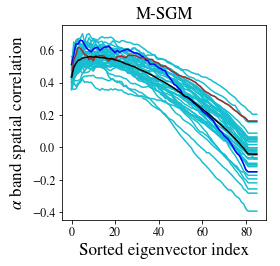

In [4]:
roi = 86

optparam = np.loadtxt("../data/MSGM_Reordered_matlab_500iter.csv",delimiter=",")
nsubs = len(optparam[:,0])

spcorrl = []
spcorrlmax = []
eigvec_al = []
eigvec1_al = []
for i in range(nsubs):
    spcorr, eigvec, summed_PSD, eig_ind = subsc(ind_conn, ind_psd_db, rois_with_MEG, fvec, "alpha", roi, i)
    spcorrl.append(spcorr)
    spcorrlmax.append(max(spcorr))
    maxind = np.argmax(spcorr)
    eigvec_al.append(eig_ind[0:maxind+1])
    eigvec1_al.append(eig_ind[0])
spcorrl = np.asarray(spcorrl) # It should be Nsubs X rois_with_MEG

fig, ax = plt.subplots(figsize=(4, 3.8))

for i in range(nsubs):
    ax.plot(range(roi), spcorrl[i,:], color = "tab:cyan")

spcorrsub, eigvecsub, summed_PSD_sub, eig_ind = subsc(ind_conn, ind_psd_db, rois_with_MEG, fvec, "alpha", roi, 35)
print(spcorrsub[0])
spmax = np.argmax(spcorrsub)
print(spcorrsub[spmax])
eigvec_summed = np.sum(eigvecsub[:,0:(spmax+1)], axis = 1)
ax.plot(range(roi), spcorrsub, color = "blue")

spcorrsub, eigvecsub, summed_PSD_sub, eig_ind = subsc(ind_conn, ind_psd_db, rois_with_MEG, fvec, "alpha", roi, 15)
print(spcorrsub[0])
spmax = np.argmax(spcorrsub)
print(spcorrsub[spmax])
eigvec_summed = np.sum(eigvecsub[:,0:(spmax+1)], axis = 1)
ax.plot(range(roi), spcorrsub, color = "brown")


ax.plot(range(roi),np.mean(spcorrl,axis=0), color = "k")
ax.set_title("M-SGM", fontsize = 17)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel(r'Sorted eigenvector index',fontsize=17)
plt.ylabel(r'$\alpha$ band spatial correlation',labelpad=12,fontsize=17)

plt.tight_layout()

## Generate distributions of the eigenmodes

Text(0.5, 0, 'Eigenvector index')

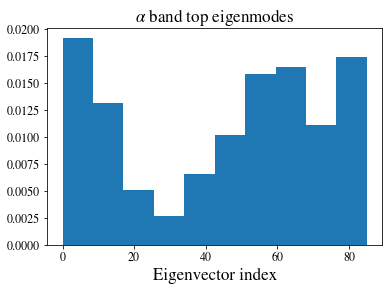

In [5]:
plt.hist(list(np.concatenate(eigvec_al).flat), density=True);
plt.title(r'$\alpha$ band top eigenmodes',fontsize=17)
plt.xlabel(r'Eigenvector index', fontsize = 17)

## Generate distributions of the eigenmodes

Text(0.5, 0, 'Eigenvector index')

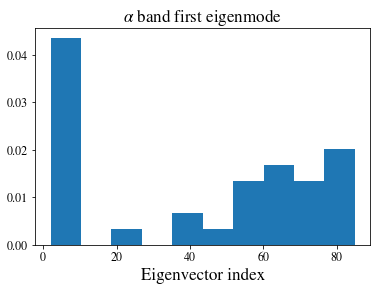

In [6]:
plt.hist(eigvec1_al, density=True);
plt.title(r'$\alpha$ band first eigenmode',fontsize=17)
plt.xlabel(r'Eigenvector index', fontsize = 17)

## Spatial correlations for the beta frequency band

/Users/parul/Software/miniconda3/envs/spectrome/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/parul/Software/miniconda3/envs/spectrome/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


0.43096021672615237
0.6485039563455114


/Users/parul/Software/miniconda3/envs/spectrome/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


0.49382114017702833
0.6720709120422087


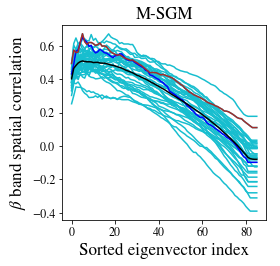

In [7]:
optparam = np.loadtxt("../data/MSGM_Reordered_matlab_500iter.csv",delimiter=",")
nsubs = len(optparam[:,0])

spcorrl = []
spcorrlmax = []
eigvec_bl = []
eigvec1_bl = []
for i in range(nsubs):
    spcorr, eigvec, summed_PSD, eig_ind = subsc(ind_conn, ind_psd_db, rois_with_MEG, fvec, "beta", roi, i)
    spcorrl.append(spcorr)
    spcorrlmax.append(max(spcorr))
    maxind = np.argmax(spcorr)
    eigvec_bl.append(eig_ind[0:maxind+1])
    eigvec1_bl.append(eig_ind[0])
spcorrl = np.asarray(spcorrl) # It should be Nsubs X rois_with_MEG

fig, ax = plt.subplots(figsize=(4, 3.8))

for i in range(nsubs):
    ax.plot(range(roi), spcorrl[i,:], color = "tab:cyan")

spcorrsub, eigvecsub, summed_PSD_sub, eig_ind = subsc(ind_conn, ind_psd_db, rois_with_MEG, fvec, "beta", roi, 2)
print(spcorrsub[0])
spmax = np.argmax(spcorrsub)
print(spcorrsub[spmax])
eigvec_summed = np.sum(eigvecsub[:,0:(spmax+1)], axis = 1)
ax.plot(range(roi), spcorrsub, color = "blue") 


spcorrsub, eigvecsub, summed_PSD_sub, eig_ind = subsc(ind_conn, ind_psd_db, rois_with_MEG, fvec, "beta", roi, 15)
print(spcorrsub[0])
spmax = np.argmax(spcorrsub)
print(spcorrsub[spmax])
eigvec_summed = np.sum(eigvecsub[:,0:(spmax+1)], axis = 1)
ax.plot(range(roi), spcorrsub, color = "brown") 


ax.plot(range(roi),np.mean(spcorrl,axis=0), color = "k")
ax.set_title("M-SGM", fontsize = 17)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel(r'Sorted eigenvector index',fontsize=17)
plt.ylabel(r'$\beta$ band spatial correlation',labelpad=12,fontsize=17)

plt.tight_layout()

Text(0.5, 0, 'Eigenvector index')

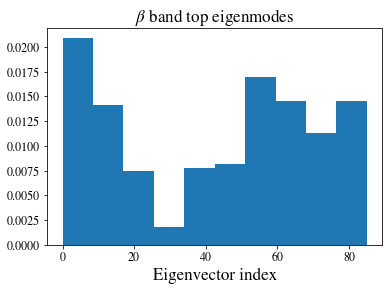

In [8]:
plt.hist(list(np.concatenate(eigvec_bl).flat), density=True);
plt.title(r'$\beta$ band top eigenmodes',fontsize=17)
plt.xlabel(r'Eigenvector index', fontsize = 17)

Text(0.5, 0, 'Eigenvector index')

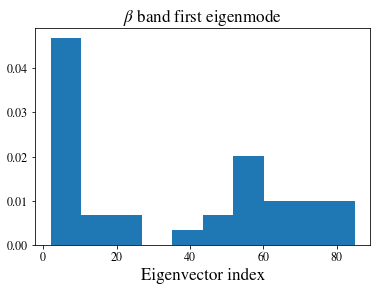

In [9]:
plt.hist(eigvec1_bl, density=True);
plt.title(r'$\beta$ band first eigenmode',fontsize=17)
plt.xlabel(r'Eigenvector index', fontsize = 17)